# Ejercicio 2

In [38]:
# --------- Leer el texto desde el archivo ---------
with open("Pradera\datos\informacion\Mecanica_del_juego.txt", "r", encoding="utf-8") as file:
    texto = file.read()


In [39]:
import re
# Limpieza del texto (antes de fragmentar). Elimino espacios innecesarios
def limpiar_texto(texto):
    texto = texto.strip()
    texto = re.sub(r'\s+', ' ', texto)
    return texto

texto_limpio = limpiar_texto(texto)

In [40]:
from langchain.text_splitter import CharacterTextSplitter

# Esto intenta no cortar palabras ni oraciones, buscando separadores (como "\n" o ". ") antes del límite.

# Crear el splitter
splitter = CharacterTextSplitter(
    separator="\n",            
    chunk_size=200, # Divide cada 200 caracteres
    chunk_overlap=0,           
    length_function=len
)

# Generar los fragmentos
fragmentos = splitter.split_text(texto)

# Ver cantidad de fragmentos
print(f"Total de fragmentos generados: {len(fragmentos)}")

# Ver algunos ejemplos
for i, frag in enumerate(fragmentos[:3]):
    print(f"\n--- Fragmento {i+1} ---\n{frag}")

Created a chunk of size 301, which is longer than the specified 200
Created a chunk of size 275, which is longer than the specified 200
Created a chunk of size 426, which is longer than the specified 200
Created a chunk of size 288, which is longer than the specified 200
Created a chunk of size 1086, which is longer than the specified 200
Created a chunk of size 668, which is longer than the specified 200
Created a chunk of size 466, which is longer than the specified 200
Created a chunk of size 467, which is longer than the specified 200
Created a chunk of size 395, which is longer than the specified 200
Created a chunk of size 224, which is longer than the specified 200
Created a chunk of size 254, which is longer than the specified 200
Created a chunk of size 208, which is longer than the specified 200
Created a chunk of size 425, which is longer than the specified 200
Created a chunk of size 512, which is longer than the specified 200
Created a chunk of size 500, which is longer th

Total de fragmentos generados: 49

--- Fragmento 1 ---
Conviértete en un explorador que compite con otros por ver quién es el observador de la naturaleza más hábil en un viaje para el que no se necesita más que el deseo por descubrir los misterios de la naturaleza y una mirada llena de curiosidad por cada pequeño detalle que nos encontremos en el camino.

--- Fragmento 2 ---
Así se nos presenta Pradera, diseñado por Klemens Kalicki, responsable de Dream Home. El juego fue publicado en 2021 por Rebel Studio en una versión en polaco. De las ilustraciones se encarga Karolina Kijak, siendo esta su primera incursión en el mundo de los juegos de mesa.

--- Fragmento 3 ---
Se encuentra publicado en español por Asmodee Ibérica (aunque el juego es completamente independiente del idioma). Permite partidas de 1 a 4 jugadores, con una edad mínima sugerida de 10 años y una duración aproximada de entre 60 y 90 minutos. El precio de venta al público es de 44,99€. Para esta reseña se ha utilizado una 

In [41]:
# Vectorización de los fragmentos
from sentence_transformers import SentenceTransformer
from prettytable import PrettyTable

# Cargamos el modelo preentrenado multilingüe
modelo = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Codificamos los fragmentos
embeddings = modelo.encode(fragmentos, convert_to_tensor=True)

In [42]:
from sentence_transformers import util
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
import Levenshtein as lev
import numpy as np


frases_busqueda = [
    "¿Cuáles son las reglas básicas del juego de mesa?",
    "Cómo se juega a este juego de mesa",
    "Objetivo principal del juego",
    "Tipos de cartas en el juego",
    "Estrategias ganadoras en juegos de mesa",
    "Número de jugadores recomendado para este juego",
    "¿Es este juego cooperativo o competitivo?",
    "Historia del juego de mesa",
    "¿Qué hace especial este juego?",
    "¿Cómo se distribuyen las cartas en este juego?"
]

# Codificar las frases de búsqueda
embeddings_busqueda = modelo.encode(frases_busqueda, convert_to_tensor=True)

# Función para calcular la similitud del coseno
def similitud_coseno(embedding1, embedding2):
    return util.cos_sim(embedding1, embedding2).item()

# Función para calcular la distancia de Jaccard
def distancia_jaccard(str1, str2):
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return 1 - intersection / union  # Jaccard devuelve la distancia, no la similitud

# Función para calcular la distancia de Levenshtein
def distancia_levenshtein(str1, str2):
    return lev.distance(str1, str2)

# Función para calcular el índice de Dice
def indice_dice(str1, str2):
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = len(set1.intersection(set2))
    return 2 * intersection / (len(set1) + len(set2))  # Dice devuelve la similitud

# Función para calcular la similitud de Jaro-Winkler
def similitud_jaro_winkler(str1, str2):
    return fuzz.ratio(str1, str2) / 100  # Jaro-Winkler es un porcentaje

# Crear una tabla para mostrar los resultados
tabla = PrettyTable()
tabla.field_names = ["Frase de Búsqueda", "Fragmento", "Similitud Coseno", "Distancia Jaccard", "Distancia Levenshtein", "Índice Dice", "Similitud Jaro-Winkler"]

# Comparar todas las frases de búsqueda con todos los fragmentos
for i, frase in enumerate(frases_busqueda):
    for j, fragmento in enumerate(fragmentos):
        similitud_cos = similitud_coseno(embeddings_busqueda[i], embeddings[j])
        jaccard = distancia_jaccard(frase, fragmento)
        levenshtein = distancia_levenshtein(frase, fragmento)
        dice = indice_dice(frase, fragmento)
        jaro_winkler = similitud_jaro_winkler(frase, fragmento)

        # Añadir la fila a la tabla
        tabla.add_row([frase, fragmento, f"{similitud_cos:.4f}", f"{jaccard:.4f}", f"{levenshtein:.4f}", f"{dice:.4f}", f"{jaro_winkler:.4f}"])

# Mostrar la tabla con los resultados
print(tabla)


+---------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

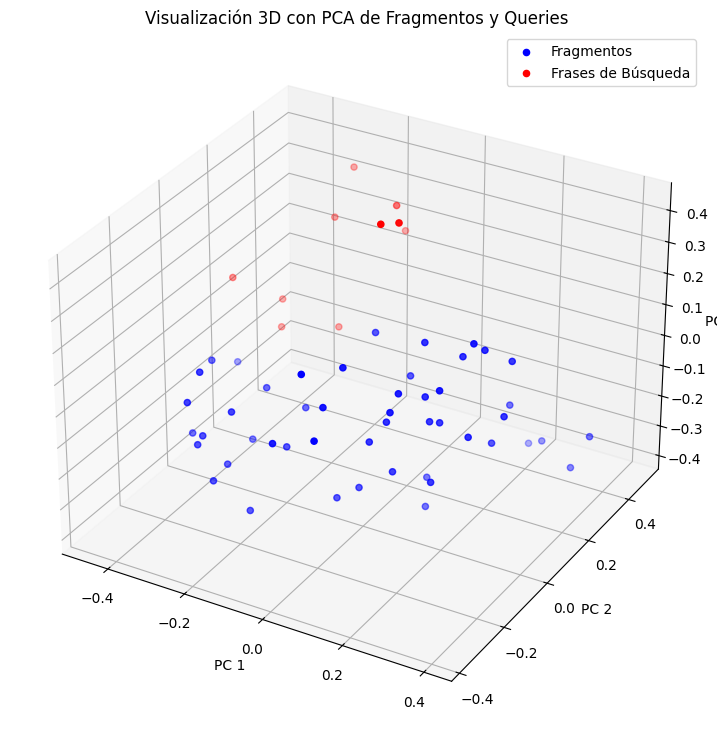

In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Combina los embeddings de fragmentos y frases de búsqueda
todos_embeddings = embeddings.cpu().numpy().tolist() + embeddings_busqueda.cpu().numpy().tolist()


# Aplica PCA para reducir a 3 dimensiones
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(todos_embeddings)

# Separa fragmentos y frases de búsqueda
num_fragmentos = len(fragmentos)
emb_frag = embeddings_3d[:num_fragmentos]
emb_query = embeddings_3d[num_fragmentos:]

# Visualización 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Fragmentos en azul
ax.scatter(emb_frag[:, 0], emb_frag[:, 1], emb_frag[:, 2], c='blue', label='Fragmentos')
# Frases de búsqueda en rojo
ax.scatter(emb_query[:, 0], emb_query[:, 1], emb_query[:, 2], c='red', label='Frases de Búsqueda')



ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Visualización 3D con PCA de Fragmentos y Queries')
ax.legend()
plt.show()


# Ejercicio 3

In [44]:
import spacy

# Carga el modelo en español con soporte para POS y NER
nlp = spacy.load('es_core_news_lg')

# Creamos una lista para almacenar los sustantivos por fragmento para su posterior análisis
sustantivos_por_fragmento = []

for i, fragmento in enumerate(fragmentos):
    doc = nlp(fragmento)
    
    print(f"\n--- Fragmento {i+1} ---")
    print(f"Texto: {fragmento}\n")

    # 1. Extraer frases nominales (noun_chunks = frases con núcleo sustantivo)
    print("Frases nominales (POS):")
    for chunk in doc.noun_chunks:
        print(f" - {chunk.text}")

    # 2. Extraer entidades nombradas (NER)
    print("\nEntidades nombradas (NER):")
    for ent in doc.ents:
        print(f" - {ent.text} ({ent.label_})")

    # 3. Sustantivos (guardarlos para análisis posterior)
    sustantivos = [token.lemma_.lower() for token in doc if token.pos_ == "NOUN"]
    print("\nSustantivos extraídos (lemmatizados):")
    print(sustantivos)
    
    # Guardar en la lista principal
    sustantivos_por_fragmento.append(sustantivos)


--- Fragmento 1 ---
Texto: Conviértete en un explorador que compite con otros por ver quién es el observador de la naturaleza más hábil en un viaje para el que no se necesita más que el deseo por descubrir los misterios de la naturaleza y una mirada llena de curiosidad por cada pequeño detalle que nos encontremos en el camino.

Frases nominales (POS):
 - Conviértete
 - un explorador
 - que
 - otros
 - quién
 - la naturaleza
 - un viaje
 - el que
 - más que el deseo
 - los misterios
 - la naturaleza
 - una mirada
 - curiosidad
 - cada pequeño detalle
 - que
 - el camino

Entidades nombradas (NER):

Sustantivos extraídos (lemmatizados):
['explorador', 'observador', 'naturaleza', 'viaje', 'deseo', 'misterio', 'naturaleza', 'mirada', 'curiosidad', 'detalle', 'camino']

--- Fragmento 2 ---
Texto: Así se nos presenta Pradera, diseñado por Klemens Kalicki, responsable de Dream Home. El juego fue publicado en 2021 por Rebel Studio en una versión en polaco. De las ilustraciones se encarga Karo

In [45]:
# CODIGO PARA VISUALIZAR UN FRAGMENTO EN PARTICULAR

indice_fragmento = 2  

fragmento = fragmentos[indice_fragmento]
doc = nlp(fragmento)

print(f"\n--- Fragmento {indice_fragmento + 1} ---")
print(f"Texto: {fragmento}\n")

# 1. Frases nominales (POS)
print("Frases nominales (POS):")
for chunk in doc.noun_chunks:
    print(f" - {chunk.text}")

# 2. Entidades nombradas con explicación (NER)
print("\nEntidades nombradas (NER):")
if doc.ents:
    for ent in doc.ents:
        print(f" - Entidad: {ent.text}, Etiqueta: {ent.label_}, Explicación: {spacy.explain(ent.label_)}")
else:
    print("No se encontraron entidades nombradas en este fragmento.")


--- Fragmento 3 ---
Texto: Se encuentra publicado en español por Asmodee Ibérica (aunque el juego es completamente independiente del idioma). Permite partidas de 1 a 4 jugadores, con una edad mínima sugerida de 10 años y una duración aproximada de entre 60 y 90 minutos. El precio de venta al público es de 44,99€. Para esta reseña se ha utilizado una copia de la versión en español de Asmodee Ibérica, que la propia editorial nos ha cedido amablemente.

Frases nominales (POS):
 - español
 - Asmodee Ibérica
 - el juego
 - idioma
 - partidas
 - 4 jugadores
 - , con una edad mínima
 - 10 años
 - una duración
 - entre 60 y 90 minutos
 - El precio
 - venta
 - público
 - esta reseña
 - una copia
 - la versión
 - español
 - Asmodee Ibérica
 - la propia editorial

Entidades nombradas (NER):
 - Entidad: Asmodee Ibérica, Etiqueta: MISC, Explicación: Miscellaneous entities, e.g. events, nationalities, products or works of art
 - Entidad: El precio de venta al público, Etiqueta: MISC, Explicación: M

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
import textdistance

# 🔹 Similitud de Jaccard
def similitud_jaccard(lista1, lista2):
    return textdistance.jaccard.normalized_similarity(set(lista1), set(lista2))


# 🔹 Similitud de Levenshtein
def similitud_levenshtein(lista1, lista2):
    if not lista1 or not lista2:
        return 0.0
    puntajes = []
    for palabra1 in lista1:
        mejores_similitudes = []
        for palabra2 in lista2:
            dist = distancia_levenshtein(palabra1, palabra2)
            max_len = max(len(palabra1), len(palabra2))
            if max_len == 0:
                similitud = 1.0  # ambas palabras vacías
            else:
                similitud = 1 - dist / max_len
            mejores_similitudes.append(similitud)
        puntajes.append(max(mejores_similitudes))
    return np.mean(puntajes)


# 🔹 Índice de Dice
def similitud_dice(lista1, lista2):
    return textdistance.dice.normalized_similarity(set(lista1), set(lista2))


# 🔹 Similitud del Coseno 
def similitud_coseno_bow(lista1, lista2):
    documentos = [' '.join(lista1), ' '.join(lista2)] # convierte listas a cadenas
    vectorizer = CountVectorizer().fit_transform(documentos)
    vectores = vectorizer.toarray()
    return cosine_similarity([vectores[0]], [vectores[1]])[0][0]

# 🔹 Similitud de Jaro-Winkler (promedio entre palabras)
def similitud_jaro_winkler(lista1, lista2):
    if not lista1 or not lista2:
        return 0.0
    puntajes = []
    for palabra1 in lista1:
        mejores_similitudes = [fuzz.WRatio(palabra1, palabra2) for palabra2 in lista2]
        puntajes.append(max(mejores_similitudes))
    return np.mean(puntajes) / 100  # para dejarlo en [0,1]

In [47]:
# Ejemplo: comparar fragmento 0 y 1
lista1 = sustantivos_por_fragmento[0]
lista2 = sustantivos_por_fragmento[1]

print("Similitud Jaccard:", similitud_jaccard(lista1, lista2))
print("Similitud Dice:", similitud_dice(lista1, lista2))
print("Similitud Coseno (BoW):", similitud_coseno_bow(lista1, lista2))
print("Similitud Levenshtein:", similitud_levenshtein(lista1, lista2))
print("Similitud Jaro-Winkler:", similitud_jaro_winkler(lista1, lista2))

Similitud Jaccard: 0.0
Similitud Dice: 0.0
Similitud Coseno (BoW): 0.0
Similitud Levenshtein: 0.2895316804407713
Similitud Jaro-Winkler: 0.48727272727272725


In [48]:
print(set(sustantivos_por_fragmento[1]))

{'ilustración', 'mesa', 'responsable', 'mundo', 'juego', '2021', 'incursión', 'versión', 'polaco'}


# Ejercicio 4

In [49]:
from langdetect import detect
import os
import pandas as pd

carpeta = "Pradera/datos/informacion"

# Lista para guardar los resultados
datos = []

# Recorrer todos los archivos en la carpeta
for nombre_archivo in os.listdir(carpeta):
    ruta_archivo = os.path.join(carpeta, nombre_archivo)

    # Solo procesar archivos .txt
    if nombre_archivo.endswith(".txt"):
        with open(ruta_archivo, "r", encoding="utf-8") as archivo:
            texto = archivo.read()

            # Detectar idioma
            try:
                idioma = detect(texto)
            except:
                idioma = "desconocido"

            # Guardar en la lista
            datos.append({
                "archivo": nombre_archivo,
                "idioma": idioma,
                "texto": texto
            })

# Crear el DataFrame
df_idiomas = pd.DataFrame(datos)

# Mostrar el DataFrame
df_idiomas.head()


,archivo,idioma,texto
0,comentarios.txt,es,1 Espectacular. Desde que se anunció ya me lla...
1,descripcion_general.txt,en,Meadow is an engaging set collection game with...
2,enlaces_imagenes.txt,fr,https://i0.wp.com/misutmeeple.com/wp-content/u...
3,enlaces_pagina.txt,es,#Colecciones\nhttps://misutmeeple.com/tag/cole...
4,foro_general.txt,en,Missed card packs ?: Hello everyone\n\nAfter c...


# Ejercicio 5

In [50]:
# Ruta al archivo
ruta_archivo = "Pradera/datos/informacion/comentarios.txt"

# Leer reseñas correctamente
resenias = []
reseña_actual = ""

with open(ruta_archivo, "r", encoding="utf-8") as file:
    for linea in file:
        linea = linea.strip()
        if not linea:
            continue
        # Si la línea empieza con un número y un espacio, es una nueva reseña
        if re.match(r"^\d+\s", linea):
            if reseña_actual:
                resenias.append(reseña_actual.strip())  # Guardar la anterior
            # Eliminar el número y guardar el nuevo comienzo
            reseña_actual = re.sub(r"^\d+\s+", "", linea)
        else:
            reseña_actual += " " + linea  # Continuación de la reseña actual

# Guardar la última reseña si quedó alguna
if reseña_actual:
    resenias.append(reseña_actual.strip())

# Crear DataFrame
df_resenias = pd.DataFrame(resenias, columns=["texto"])

# Verificar una reseña puntual
print(resenias[49])


Un juegazo. Y con la ultima expansión aun mas. xD


In [51]:
df_resenias.head()

,texto
0,Espectacular. Desde que se anunció ya me llamó...
1,A mi me tiene encandilado. No deja de ser un j...
2,"Gran reseña, como siempre. Está gustando mucho..."
3,A mi siempre me deja con ganas de seguir jugan...
4,"Hola Iván, la verdad es que me has sorprendido..."


In [52]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Device set to use cpu


In [53]:
# Agrego etiquetas para que sea mas representativo
etiquetas_map = {
    "1 star": "Muy negativo",
    "2 stars": "Negativo",
    "3 stars": "Neutral",
    "4 stars": "Positivo",
    "5 stars": "Muy positivo"
}

# Analizar el sentimiento de cada reseña utilizando el modelo preentrenado
sentimientos = []
for texto in df_resenias["texto"]:
    resultado = nlp(texto[:512])[0]  # Truncar texto largo
    etiqueta = resultado["label"]
    sentimiento = etiquetas_map.get(etiqueta, "Desconocido")
    sentimientos.append(sentimiento)

df_resenias["Sentimiento"] = sentimientos


In [54]:
df_resenias.head(5)


,texto,Sentimiento
0,Espectacular. Desde que se anunció ya me llamó...,Muy positivo
1,A mi me tiene encandilado. No deja de ser un j...,Muy positivo
2,"Gran reseña, como siempre. Está gustando mucho...",Positivo
3,A mi siempre me deja con ganas de seguir jugan...,Positivo
4,"Hola Iván, la verdad es que me has sorprendido...",Neutral


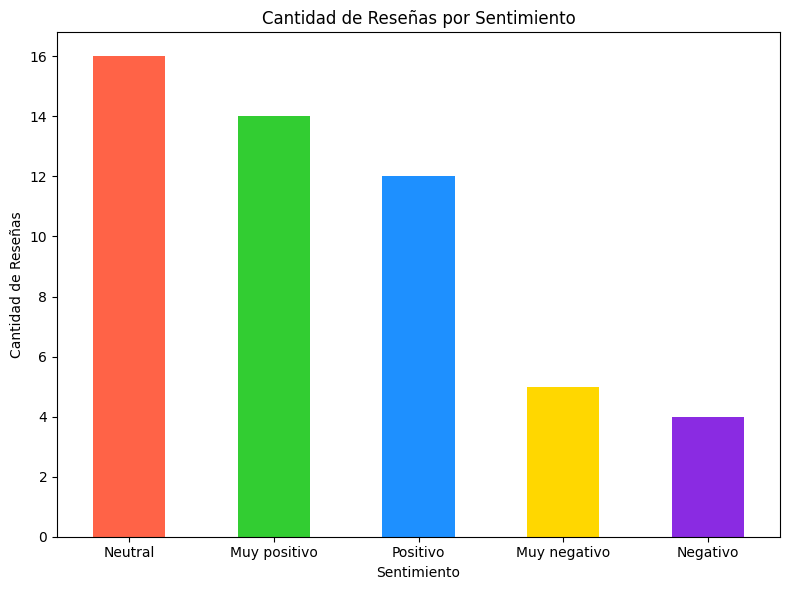

In [55]:
# Visualización de Cantidad de Reseñas por Sentimiento
sentimiento_counts = df_resenias['Sentimiento'].value_counts()


plt.figure(figsize=(8, 6))
sentimiento_counts.plot(kind='bar', color=['#FF6347', '#32CD32', '#1E90FF', '#FFD700', '#8A2BE2'])
plt.title('Cantidad de Reseñas por Sentimiento')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Reseñas')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [56]:
# Cargar modelo para búsqueda semántica asimétrica
modelo = SentenceTransformer('msmarco-MiniLM-L-6-v3')

# Consultas simuladas
consultas = [
    "¿Qué tan educativo es el juego?",
    "¿El juego es divertido para jugar con niños?",
    "¿Vale la pena por los componentes?",
    "¿Es entretenido a largo plazo?",
    "¿El juego es complejo o fácil de aprender?",
    "¿Es bueno para jugar en familia?",
    "¿Se siente repetitivo después de algunas partidas?"
]

# Embeddings de consultas
incrustaciones_consultas = modelo.encode(consultas, convert_to_tensor=True)

# Embeddings de reseñas (respuestas)
respuestas = df_resenias["texto"].tolist()
incrustaciones_respuestas = modelo.encode(respuestas, convert_to_tensor=True)

# Elegir tipo de sentimiento deseado
sentimiento_deseado = "Muy positivo"


# Buscar la mejor respuesta para cada consulta
for i, consulta in enumerate(consultas):
    similitudes = util.cos_sim(incrustaciones_consultas[i], incrustaciones_respuestas)[0]
    mejores_indices = similitudes.topk(k=10).indices.tolist()

    print(f"🔍 Consulta: {consulta}")
    count = 0
    for idx in mejores_indices:
        if df_resenias.iloc[idx]['Sentimiento'] == sentimiento_deseado:
            print(f"\n🔹 Reseña relacionada (Similitud: {similitudes[idx]:.4f}):")
            print(f"{respuestas[idx]}")
            print(f"📊 Sentimiento: {df_resenias.iloc[idx]['Sentimiento']}")
            count += 1
            if count >= 3:
                break
    print("=" * 100)

🔍 Consulta: ¿Qué tan educativo es el juego?

🔹 Reseña relacionada (Similitud: 0.4644):
Muchísimas gracias!! Me alegra de que el contenido os sirva. Y Pradera es de esos juegos que entran solos en cualquier ludoteca porque lo tiene todo como juego cuasi familiar.
📊 Sentimiento: Muy positivo

🔹 Reseña relacionada (Similitud: 0.4637):
Muchas gracias por la reseña, Iván. En mi caso lo compré cuando salió porque había visto como se jugaba y me había llamado mucho la atención. En casa ha caído de pie y nos encanta, ha sido un gran acierto. Pero el mejor acierto es seguir tu blog, por tema económico y de espacio tengo que ser muy selectivo a la hora de comprar y al ver la nota que le has puesto a este  juego pienso que he acertado, al final me estas contagiando el buen gusto. Solamente llevamos un par de años metidos de lleno en el mundillo y muchos de los juegos de nuestra colección te los debemos a ti, la facilidad de ver a través de tus reseñas si el juego nos cuadra nos ayuda muchísimo, a

# Ejercicio 6

In [57]:
consultas_categorizadas = [
    {"consulta": "¿Qué es el juego Pradera?", "categoria": "Información"},
    {"consulta": "¿Cuál es el objetivo principal de Pradera?", "categoria": "Información"},
    {"consulta": "¿Cuáles son los componentes del juego?", "categoria": "Información"},
    {"consulta": "¿Cuántos jugadores pueden jugar Pradera?", "categoria": "Información"},
    {"consulta": "¿Cuál es la duración aproximada de una partida?", "categoria": "Información"},
    {"consulta": "¿Cómo se prepara el juego antes de empezar?", "categoria": "Información"},
    {"consulta": "¿Cuáles son las reglas básicas para ganar?", "categoria": "Información"},
    {"consulta": "¿Cómo funciona el sistema de puntuación?", "categoria": "Información"},
    {"consulta": "¿Qué habilidades se desarrollan jugando Pradera?", "categoria": "Información"},
    {"consulta": "¿Dónde puedo encontrar el reglamento oficial?", "categoria": "Información"},
    {"consulta": "¿Existen variantes oficiales del juego?", "categoria": "Información"},
    {"consulta": "¿Hay tutoriales en video disponibles?", "categoria": "Información"},
    {"consulta": "¿Qué estrategias se recomiendan para principiantes?", "categoria": "Información"},
    {"consulta": "¿Qué idioma tiene el reglamento original?", "categoria": "Información"},
    {"consulta": "¿Se puede jugar en línea o sólo en físico?", "categoria": "Información"},
    {"consulta": "¿Quién diseñó el juego Pradera?", "categoria": "Información"},
    {"consulta": "¿Cuál es la historia detrás del juego?", "categoria": "Información"},
    {"consulta": "¿Dónde puedo comprar Pradera?", "categoria": "Información"},
    {"consulta": "¿Hay alguna expansión para el juego?", "categoria": "Información"},
    {"consulta": "¿Qué tipo de tablero utiliza Pradera?", "categoria": "Información"},
    {"consulta": "¿Qué tipo de dados se usan en Pradera?", "categoria": "Información"},
    {"consulta": "¿Cómo se usa el tablero durante el juego?", "categoria": "Información"},
    {"consulta": "¿Cuántas cartas hay en el mazo?", "categoria": "Información"},
    {"consulta": "¿Cuál es la edad recomendada para jugar?", "categoria": "Información"},
    {"consulta": "¿Cómo se inicia una partida?", "categoria": "Información"},
    {"consulta": "¿Se puede jugar Pradera en equipos?", "categoria": "Información"},
    {"consulta": "¿Qué pasa si un jugador se queda sin cartas?", "categoria": "Información"},
    {"consulta": "¿Cómo se realiza un movimiento válido?", "categoria": "Información"},
    {"consulta": "¿Cuáles son las penalizaciones en el juego?", "categoria": "Información"},
    {"consulta": "¿Cómo se gana el desempate?", "categoria": "Información"},
    {"consulta": "¿Hay reglas especiales para la variante en línea?", "categoria": "Información"},
    {"consulta": "¿Qué tipo de estrategias avanzadas existen?", "categoria": "Información"},
    {"consulta": "¿Qué recursos vienen incluidos en la caja?", "categoria": "Información"},
    {"consulta": "¿Es necesario un árbitro para jugar?", "categoria": "Información"},
    {"consulta": "¿Cuánto tiempo dura la preparación antes del juego?", "categoria": "Información"},
    {"consulta": "¿Se puede modificar el reglamento?", "categoria": "Información"},
    {"consulta": "¿Cómo se configuran las piezas?", "categoria": "Información"},
    {"consulta": "¿Qué pasa si un jugador abandona la partida?", "categoria": "Información"},
    {"consulta": "¿Cómo se realiza el conteo de puntos final?", "categoria": "Información"},
    {"consulta": "¿Existen torneos oficiales de Pradera?", "categoria": "Información"},
    {"consulta": "¿Cuál es la historia del diseño del juego?", "categoria": "Información"},
    {"consulta": "¿Quiénes son los autores del reglamento?", "categoria": "Información"},
    {"consulta": "¿Hay alguna app oficial de Pradera?", "categoria": "Información"},
    {"consulta": "¿Se pueden personalizar las piezas del juego?", "categoria": "Información"},
    {"consulta": "¿Cómo se manejan los empates en partidas múltiples?", "categoria": "Información"},
    {"consulta": "¿Qué idiomas están disponibles para el reglamento?", "categoria": "Información"},
    {"consulta": "¿Cuáles son las normas para jugar con niños?", "categoria": "Información"},
    {"consulta": "¿Qué materiales se usan para las piezas?", "categoria": "Información"},
    {"consulta": "¿Dónde puedo descargar el reglamento en PDF?", "categoria": "Información"},
    {"consulta": "¿Cuál es la mejor manera de guardar el juego?", "categoria": "Información"},
    {"consulta": "¿Cómo se resuelven disputas durante el juego?", "categoria": "Información"},
    {"consulta": "¿Se recomienda usar el juego para clases educativas?", "categoria": "Información"},
    {"consulta": "¿Qué variantes caseras existen para el juego?", "categoria": "Información"},
    {"consulta": "¿Se pueden jugar partidas rápidas?", "categoria": "Información"},
    {"consulta": "¿Cómo afecta el número de jugadores la duración?", "categoria": "Información"},
    {"consulta": "¿Qué tipo de tableros alternativos se pueden usar?", "categoria": "Información"},
    {"consulta": "¿Se puede jugar con menos piezas?", "categoria": "Información"},
    {"consulta": "¿Qué reglas se aplican en el modo solitario?", "categoria": "Información"},
    {"consulta": "¿Cuáles son las recomendaciones para jugadores nuevos?", "categoria": "Información"},
    {"consulta": "¿Cómo se realiza el setup inicial en la variante avanzada?", "categoria": "Información"},
    {"consulta": "¿Qué tipos de cartas existen en el juego?", "categoria": "Información"},
    {"consulta": "¿Se puede descargar material adicional para el juego?", "categoria": "Información"},
    {"consulta": "¿Cuáles son los elementos de arte del juego?", "categoria": "Información"},
    {"consulta": "¿Existen expansiones oficiales?", "categoria": "Información"},
    {"consulta": "¿Cuál es la mejor estrategia para jugar en familia?", "categoria": "Información"},
    {"consulta": "¿Qué edad mínima recomienda el fabricante?", "categoria": "Información"},
    {"consulta": "¿Cuál es la función de cada tipo de pieza?", "categoria": "Información"},
    {"consulta": "¿Cómo se hace el mantenimiento de las piezas?", "categoria": "Información"},
    {"consulta": "¿Qué sucede si se pierde alguna pieza?", "categoria": "Información"},
    {"consulta": "¿Cuáles son las reglas para partidas en línea?", "categoria": "Información"},
    {"consulta": "¿Se puede jugar Pradera en dispositivos móviles?", "categoria": "Información"},
    {"consulta": "¿Qué tan recomendado es el juego para principiantes?", "categoria": "Información"},
    {"consulta": "¿Qué habilidades sociales promueve el juego?", "categoria": "Información"},
    {"consulta": "¿Cuál es el nivel de complejidad del juego?", "categoria": "Información"},
    {"consulta": "¿Cuántas partidas se pueden jugar con una caja?", "categoria": "Información"},
    {"consulta": "¿Qué soporte técnico ofrece el fabricante?", "categoria": "Información"},
    {"consulta": "¿Se pueden imprimir reglas adicionales?", "categoria": "Información"},
    {"consulta": "¿Existen tutoriales en otros idiomas?", "categoria": "Información"},
    {"consulta": "¿Qué tipos de variantes están permitidas en torneos?", "categoria": "Información"},
    {"consulta": "¿Cómo se puntúan las acciones especiales?", "categoria": "Información"},
    {"consulta": "¿Cuál es la política de devolución del juego?", "categoria": "Información"},
    {"consulta": "¿Se recomienda jugar con reloj de tiempo?", "categoria": "Información"},
    {"consulta": "¿Cómo se usa la carta comodín?", "categoria": "Información"},
    {"consulta": "¿Cuándo fue lanzado el juego al mercado?", "categoria": "Información"},
    {"consulta": "¿Qué hace especial a Pradera frente a otros juegos?", "categoria": "Información"},
    {"consulta": "¿Cuál es la temática principal del juego?", "categoria": "Información"},
    {"consulta": "¿Qué tipo de mecánicas utiliza Pradera?", "categoria": "Información"},
    {"consulta": "¿Qué elementos del juego fomentan la colaboración?", "categoria": "Información"},
    {"consulta": "¿Dónde están ubicadas las reglas para el modo torneo?", "categoria": "Información"},
    {"consulta": "¿Existen ediciones especiales del juego?", "categoria": "Información"},
    {"consulta": "¿Qué son las cartas de evento?", "categoria": "Información"},
    {"consulta": "¿Cómo se puede aprender a jugar rápido?", "categoria": "Información"},
    {"consulta": "¿Qué papel juegan los recursos en el juego?", "categoria": "Información"},
    {"consulta": "¿Se pueden jugar partidas con menos jugadores?", "categoria": "Información"},
    {"consulta": "¿Qué pasa si se rompen las cartas?", "categoria": "Información"},
    {"consulta": "¿Cuáles son las fases del juego?", "categoria": "Información"},
    {"consulta": "¿Cómo se asignan los turnos?", "categoria": "Información"},
    {"consulta": "¿Qué reglas aplican para el modo cooperativo?", "categoria": "Información"},
    {"consulta": "¿Qué tipo de tablero se recomienda para torneos?", "categoria": "Información"},
    {"consulta": "¿Se puede jugar Pradera con adaptaciones para discapacitados?", "categoria": "Información"},
    {"consulta": "¿Cómo es el flujo de una partida típica?", "categoria": "Información"},
    {"consulta": "¿Qué habilidades cognitivas desarrolla el juego?", "categoria": "Información"},
    {"consulta": "¿Existen limitaciones de espacio para jugar?", "categoria": "Información"},
    {"consulta": "¿Qué tamaño tiene el tablero?", "categoria": "Información"},
    {"consulta": "¿Cuántos jugadores se necesitan para una partida oficial?", "categoria": "Información"},
    {"consulta": "¿Qué materiales se usan para el tablero?", "categoria": "Información"},
    {"consulta": "¿Cuánto pesa la caja del juego?", "categoria": "Información"},
    {"consulta": "¿Hay recomendaciones para almacenar el juego?", "categoria": "Información"},
    {"consulta": "¿Cuál es la política de garantía?", "categoria": "Información"},
    {"consulta": "¿Se recomienda usar protectores para las cartas?", "categoria": "Información"},
    {"consulta": "¿Qué tamaño tienen las cartas?", "categoria": "Información"},
    {"consulta": "¿Cuál es la calidad del material de las piezas?", "categoria": "Información"},
    {"consulta": "¿Cuáles son las reglas para jugar en parejas?", "categoria": "Información"},
    {"consulta": "¿Qué elementos se pueden personalizar?", "categoria": "Información"},
    {"consulta": "¿Qué tipos de estrategias son efectivas en Pradera?", "categoria": "Información"},
    {"consulta": "¿Qué accesorios adicionales se pueden comprar?", "categoria": "Información"},
    {"consulta": "¿Cómo es el embalaje del juego?", "categoria": "Información"},
    {"consulta": "¿Cuál es la mejor forma de enseñar el juego a niños?", "categoria": "Información"},
    {"consulta": "¿Qué idiomas están soportados en el tutorial?", "categoria": "Información"},
    {"consulta": "¿Cuál es la estructura del reglamento?", "categoria": "Información"},
    {"consulta": "¿Se recomienda jugar Pradera en grupos grandes?", "categoria": "Información"},
    {"consulta": "¿Cuáles son las reglas para modificar el juego?", "categoria": "Información"},
    {"consulta": "¿Cómo interpretar las ilustraciones del reglamento?", "categoria": "Información"},
    {"consulta": "¿Qué hacer si hay una discrepancia en las reglas?", "categoria": "Información"},
    {"consulta": "¿Cuáles son las recomendaciones para partidas en exteriores?", "categoria": "Información"},
    {"consulta": "¿Cómo se usa el reloj de arena en el juego?", "categoria": "Información"},
    {"consulta": "¿Qué pasa si se pierde la conexión durante una partida en línea?", "categoria": "Información"},
    {"consulta": "¿Qué tipos de cartas especiales existen?", "categoria": "Información"},
    {"consulta": "¿Qué variantes oficiales se recomiendan para expertos?", "categoria": "Información"},
    {"consulta": "¿Cuánto tiempo dura una partida promedio?", "categoria": "Información"},
    {"consulta": "¿Qué habilidades desarrolla Pradera en los niños?", "categoria": "Información"},
    {"consulta": "¿Cuál es la mejor edad para iniciar a jugar?", "categoria": "Información"},
    {"consulta": "¿Qué diferencias hay entre la versión física y digital?", "categoria": "Información"},
    {"consulta": "¿Se pueden usar dados personalizados?", "categoria": "Información"},
    {"consulta": "¿Cómo se limpia el tablero sin dañarlo?", "categoria": "Información"},
    {"consulta": "¿Qué opciones de soporte hay para dudas sobre el juego?", "categoria": "Información"},
    {"consulta": "¿Cuáles son las normas para jugar en ferias o exposiciones?", "categoria": "Información"},
    {"consulta": "¿Qué tipos de estrategias defensivas existen?", "categoria": "Información"},
    {"consulta": "¿Cómo se usan los elementos del tutorial en la partida?", "categoria": "Información"},
    {"consulta": "¿Cuál es el papel del azar en Pradera?", "categoria": "Información"},
    {"consulta": "¿Qué tipos de tableros alternativos existen?", "categoria": "Información"},
    {"consulta": "¿Cómo se juega Pradera con solo dos jugadores?", "categoria": "Información"},
    {"consulta": "¿Cuáles son las reglas para partidas rápidas?", "categoria": "Información"},
    {"consulta": "¿Qué beneficios tiene jugar Pradera para la concentración?", "categoria": "Información"},
    {"consulta": "¿Cómo preparar el juego para un torneo escolar?", "categoria": "Información"},
    {"consulta": "¿Qué accesorios son recomendados para proteger las piezas?", "categoria": "Información"},
    {"consulta": "¿Cómo interpretar las cartas de evento?", "categoria": "Información"},
    {"consulta": "¿Qué recursos online están disponibles para aprender?", "categoria": "Información"},
    {"consulta": "¿Se puede jugar Pradera sin tablero?", "categoria": "Información"},
    {"consulta": "¿Qué tipos de modos de juego existen?", "categoria": "Información"},
    {"consulta": "¿Cuándo se recomienda usar el modo experto?", "categoria": "Información"},
    {"consulta": "¿Cuál es el puntaje promedio del juego Pradera?", "categoria": "Estadística"},
    {"consulta": "¿Cuántas personas han calificado Pradera?", "categoria": "Estadística"},
    {"consulta": "¿Cuál es la desviación estándar del rating?", "categoria": "Estadística"},
    {"consulta": "¿Qué peso tiene Pradera en términos de dificultad?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos comentarios hay sobre el juego?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos fans tiene Pradera?", "categoria": "Estadística"},
    {"consulta": "¿Cuántas visitas de página ha recibido Pradera?", "categoria": "Estadística"},
    {"consulta": "¿Cuál es el ranking general del juego?", "categoria": "Estadística"},
    {"consulta": "¿En qué puesto está Pradera en la categoría de estrategia?", "categoria": "Estadística"},
    {"consulta": "¿Qué ranking tiene Pradera en la categoría familiar?", "categoria": "Estadística"},
    {"consulta": "¿Cuántas veces se ha jugado Pradera en total?", "categoria": "Estadística"},
    {"consulta": "¿Cuántas partidas se jugaron este mes?", "categoria": "Estadística"},
    {"consulta": "¿Cuántas personas poseen el juego actualmente?", "categoria": "Estadística"},
    {"consulta": "¿Cuántas personas lo poseían antes?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos lo tienen en su lista de intercambio?", "categoria": "Estadística"},
    {"consulta": "¿Cuántas personas desean intercambiarlo?", "categoria": "Estadística"},
    {"consulta": "¿Cuántas personas lo tienen en su lista de deseos?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos jugadores tienen partes del juego?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos usuarios desean partes del juego?", "categoria": "Estadística"},
    {"consulta": "¿Cuál es el número total de votos recibidos?", "categoria": "Estadística"},
    {"consulta": "¿Cuál es la media del puntaje dado por los jugadores?", "categoria": "Estadística"},
    {"consulta": "¿Cuál fue la puntuación más común?", "categoria": "Estadística"},
    {"consulta": "¿Qué tan popular es Pradera según sus estadísticas?", "categoria": "Estadística"},
    {"consulta": "¿Cómo ha sido la actividad del juego este mes?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos usuarios únicos han jugado Pradera?", "categoria": "Estadística"},
    {"consulta": "¿Cuántas veces lo han jugado todos los usuarios en total?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos lo han jugado al menos una vez?", "categoria": "Estadística"},
    {"consulta": "¿Cuál es la tendencia de juego mensual?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos lo han eliminado de su colección?", "categoria": "Estadística"},
    {"consulta": "¿Qué lugar ocupa Pradera en los juegos más jugados?", "categoria": "Estadística"},
    {"consulta": "¿Cuál es el promedio de calificaciones que recibe Pradera?", "categoria": "Estadística"},
    {"consulta": "¿Qué tan bien valorado está Pradera por los jugadores?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos usuarios han dejado su puntuación en el juego?", "categoria": "Estadística"},
    {"consulta": "¿Cuál es la variabilidad en las calificaciones del juego?", "categoria": "Estadística"},
    {"consulta": "¿Qué nivel de complejidad le asignan los jugadores a Pradera?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos jugadores han comentado sobre el juego?", "categoria": "Estadística"},
    {"consulta": "¿Qué cantidad de personas siguen o son fans de Pradera?", "categoria": "Estadística"},
    {"consulta": "¿Cuántas visitas ha recibido la página del juego?", "categoria": "Estadística"},
    {"consulta": "¿Qué posición ocupa Pradera en el ranking global de juegos?", "categoria": "Estadística"},
    {"consulta": "¿Cómo se posiciona Pradera en la categoría de estrategia?", "categoria": "Estadística"},
    {"consulta": "¿Qué puesto tiene Pradera dentro de los juegos familiares?", "categoria": "Estadística"},
    {"consulta": "¿Con qué frecuencia se juega Pradera a lo largo del tiempo?", "categoria": "Estadística"},
    {"consulta": "¿Qué volumen de partidas se ha registrado este mes?", "categoria": "Estadística"},
    {"consulta": "¿Cuántas copias del juego están en manos de los jugadores?", "categoria": "Estadística"},
    {"consulta": "¿Qué porcentaje de jugadores solía tener el juego pero ya no?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos ejemplares están disponibles para intercambio?", "categoria": "Estadística"},
    {"consulta": "¿Qué tan demandado está Pradera en el mercado de intercambio?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos usuarios agregaron Pradera a su wishlist?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos usuarios poseen piezas o partes sueltas del juego?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos están interesados en conseguir piezas faltantes?", "categoria": "Estadística"},
    {"consulta": "¿Cuántas personas están activamente siguiendo a Pradera?", "categoria": "Estadística"},
    {"consulta": "¿Cuál es el total acumulado de jugadas de Pradera?", "categoria": "Estadística"},
    {"consulta": "¿Qué volumen de actividad se ha visto recientemente en el juego?", "categoria": "Estadística"},
    {"consulta": "¿Qué tan frecuentemente se califica el juego?", "categoria": "Estadística"},
    {"consulta": "¿Cuál es la calificación promedio ponderada de Pradera?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos jugadores tienen a Pradera en su lista de favoritos?", "categoria": "Estadística"},
    {"consulta": "¿Qué tan estable es la popularidad del juego?", "categoria": "Estadística"},
    {"consulta": "¿Cuál fue el pico de popularidad de Pradera?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos jugadores agregaron reseñas sobre el juego?", "categoria": "Estadística"},
    {"consulta": "¿En cuántas listas de intercambio aparece Pradera?", "categoria": "Estadística"},
    {"consulta": "¿Cómo varía la cantidad de partidas jugadas mes a mes?", "categoria": "Estadística"},
    {"consulta": "¿Cuántas personas nuevas han jugado Pradera este mes?", "categoria": "Estadística"},
    {"consulta": "¿Qué tan deseado es el juego por los nuevos jugadores?", "categoria": "Estadística"},
    {"consulta": "¿En cuántas colecciones aparece el juego actualmente?", "categoria": "Estadística"},
    {"consulta": "¿Cuál es el crecimiento mensual de nuevos jugadores?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos votos positivos ha recibido el juego?", "categoria": "Estadística"},
    {"consulta": "¿Cómo ha variado la valoración promedio a lo largo del tiempo?", "categoria": "Estadística"},
    {"consulta": "¿Qué lugar ocupa Pradera entre los juegos mejor calificados?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos jugadores han participado en encuestas sobre el juego?", "categoria": "Estadística"},
    {"consulta": "¿Cuál es el engagement mensual promedio del juego?", "categoria": "Estadística"},
    {"consulta": "¿Cuántos votos totales se han registrado para Pradera?", "categoria": "Estadística"},
    {"consulta": "¿Quién diseñó el juego Meadow?", "categoria": "Relación"},
    {"consulta": "¿Quién ilustró el juego Meadow?", "categoria": "Relación"},
    {"consulta": "¿Quién trabajó en el diseño gráfico de Meadow?", "categoria": "Relación"},
    {"consulta": "¿Quién fue el editor del juego Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué editoriales publicaron Meadow?", "categoria": "Relación"},
    {"consulta": "¿Cuándo fue lanzado el juego Meadow?", "categoria": "Relación"},
    {"consulta": "¿Quién desarrolló el juego Meadow?", "categoria": "Relación"},
    {"consulta": "¿Con qué otros nombres se conoce el juego Meadow?", "categoria": "Relación"},
    {"consulta": "¿Cómo se llama Meadow en japonés?", "categoria": "Relación"},
    {"consulta": "¿Qué nombres alternativos tiene Meadow en diferentes idiomas?", "categoria": "Relación"},
    {"consulta": "¿Qué relación existe entre Bryan Gerding y Nordy?", "categoria": "Relación"},
    {"consulta": "¿Quiénes colaboraron juntos en el desarrollo de Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué ilustradores han trabajado juntos en Meadow?", "categoria": "Relación"},
    {"consulta": "¿A qué categorías pertenece el juego Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué mecánicas usa el juego Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué tipo de juego es Meadow?", "categoria": "Relación"},
    {"consulta": "¿A qué familia de juegos pertenece Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué temas aborda el juego Meadow?", "categoria": "Relación"},
    {"consulta": "¿Está Meadow relacionado con juegos de ecología?", "categoria": "Relación"},
    {"consulta": "¿Qué relación hay entre Klemens Kalicki y Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué otros juegos ha diseñado Klemens Kalicki?", "categoria": "Relación"},
    {"consulta": "¿Qué relación hay entre Karolina Kijak y Katarzyna Fiebiger?", "categoria": "Relación"},
    {"consulta": "¿Quiénes han colaborado con Karolina Kijak?", "categoria": "Relación"},
    {"consulta": "¿Qué editoriales distribuyeron el juego Meadow en distintos países?", "categoria": "Relación"},
    {"consulta": "¿Qué nombres alternativos tiene Meadow en Europa del Este?", "categoria": "Relación"},
    {"consulta": "¿Qué personas estuvieron involucradas en la creación de Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos comparten mecánicas con Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué otros juegos tienen la misma categoría que Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos usan la mecánica de 'Hand Management' como Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos tienen la temática de naturaleza como Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué relación tiene Meadow con el tema de ecología?", "categoria": "Relación"},
    {"consulta": "¿Qué versión digital existe del juego Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué relación tiene Meadow con Tabletopia?", "categoria": "Relación"},
    {"consulta": "¿Quién escribió el contenido narrativo del juego Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos comparten la familia 'Theme: Nature' con Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos están en la familia 'Mechanism: Tableau Building' como Meadow?", "categoria": "Relación"},
    {"consulta": "¿Quién es Agnieszka Możejko y qué hizo en Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué papel tuvo Nordy en el desarrollo de Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué colaboraciones internas se dan en el equipo de Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué relación existe entre los ilustradores del juego Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué otras funciones tuvo Katarzyna Fiebiger además de ilustradora?", "categoria": "Relación"},
    {"consulta": "¿Qué otros juegos fueron desarrollados por Klemens Kalicki?", "categoria": "Relación"},
    {"consulta": "¿Qué editoriales participaron en la publicación internacional de Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué relación hay entre Meadow y Rebel Studio?", "categoria": "Relación"},
    {"consulta": "¿Qué editoriales publicaron Meadow en Asia?", "categoria": "Relación"},
    {"consulta": "¿Quiénes editaron el juego Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué autores tienen múltiples roles dentro del desarrollo de Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué diseñadores gráficos participaron en la creación de Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué relación hay entre Bryan Gerding y Nordy?", "categoria": "Relación"},
    {"consulta": "¿Qué autores han trabajado juntos en más de un rol dentro de Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué otros juegos han sido ilustrados por Karolina Kijak?", "categoria": "Relación"},
    {"consulta": "¿Qué nombres recibe Meadow en otros idiomas?", "categoria": "Relación"},
    {"consulta": "¿Qué conexión hay entre Meadow y el idioma japonés?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos fueron publicados también por Arclight Games?", "categoria": "Relación"},
    {"consulta": "¿Qué relación hay entre las editoriales Rebel Studio y Rebel Sp. z o.o.?", "categoria": "Relación"},
    {"consulta": "¿Qué relación tienen las editoriales con la localización del juego?", "categoria": "Relación"},
    {"consulta": "¿Qué relación hay entre las categorías 'Animals' y 'Environmental' en Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos tienen la categoría 'Card Game' igual que Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos usan el mecanismo 'Set Collection'?", "categoria": "Relación"},
    {"consulta": "¿Qué otros títulos usan el mecanismo 'Worker Placement, Different Worker Types'?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos están en la misma familia que Meadow según BGG?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos están relacionados con la familia 'Theme: Trees and Forests'?", "categoria": "Relación"},
    {"consulta": "¿Qué relación tiene Meadow con el diseño gráfico ecológico?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos han sido ilustrados por más de un artista?", "categoria": "Relación"},
    {"consulta": "¿Qué relación existe entre los editores de Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos comparten diseñador y desarrollador como Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos han sido lanzados por Galápagos Jogos?", "categoria": "Relación"},
    {"consulta": "¿Qué relación tiene Meadow con los juegos solitarios?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos tienen versiones digitales como Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué relación tiene Meadow con la plataforma Tabletopia?", "categoria": "Relación"},
    {"consulta": "¿Qué relación tiene Meadow con la categoría de juegos ambientales?", "categoria": "Relación"},
    {"consulta": "¿Qué editoriales manejan versiones multilingües de Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué relación existe entre los temas de naturaleza y ecología en Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué nombres alternativos de Meadow corresponden al idioma ruso?", "categoria": "Relación"},
    {"consulta": "¿Qué nombres alternativos de Meadow corresponden al idioma chino?", "categoria": "Relación"},
    {"consulta": "¿Qué personas están conectadas con más de un rol en Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué editorial está más asociada a la distribución original de Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué relación tiene Meadow con otros juegos de Rebel Studio?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos de Rebel Studio tienen temas similares a Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué diseñadores han trabajado con ilustradores múltiples?", "categoria": "Relación"},
    {"consulta": "¿Qué editorial distribuye tanto Meadow como otros juegos ecológicos?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos tienen mecánicas similares a 'Open Drafting' como Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué diseñadores gráficos también ilustran?", "categoria": "Relación"},
    {"consulta": "¿Qué relación hay entre escritores y diseñadores en Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué juegos han sido escritos por Agnieszka Możejko?", "categoria": "Relación"},
    {"consulta": "¿Qué autores han sido tanto editores como desarrolladores?", "categoria": "Relación"},
    {"consulta": "¿Qué otros juegos lanzados en 2021 comparten equipo creativo con Meadow?", "categoria": "Relación"},
    {"consulta": "¿Qué personas han trabajado tanto en el diseño como en la ilustración de Meadow?", "categoria": "Relación"}
    
]

df_consultas = pd.DataFrame(consultas_categorizadas, columns=["consulta", "categoria"])


In [58]:
# Podemos ver la cantidad de consultas por categoría
df_consultas['categoria'].value_counts()

categoria
Información    151
Relación        88
Estadística     71
Name: count, dtype: int64

In [59]:
# Podemos observar que hay mas de 300 consultas
df_consultas.shape

(310, 2)

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizamos las consultas usando TF-IDF
vectorizador = TfidfVectorizer()
X = vectorizador.fit_transform(df_consultas["consulta"])

In [61]:
from sklearn.preprocessing import LabelEncoder

codificador = LabelEncoder()
y = codificador.fit_transform(df_consultas["categoria"])


In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [63]:
from sklearn.linear_model import LogisticRegression

modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [64]:
from sklearn.metrics import classification_report

y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred, target_names=codificador.classes_))


              precision    recall  f1-score   support

 Estadística       0.90      0.60      0.72        15
 Información       0.80      0.93      0.86        30
    Relación       0.94      0.94      0.94        17

    accuracy                           0.85        62
   macro avg       0.88      0.82      0.84        62
weighted avg       0.86      0.85      0.85        62



In [65]:
def predecir_categoria(consulta_nueva):
    vector = vectorizador.transform([consulta_nueva])
    pred = modelo.predict(vector)
    return codificador.inverse_transform(pred)[0]

# Ejemplo
print(predecir_categoria("¿Quién ilustró el juego Meadow?"))
print(predecir_categoria("¿Cuál es el puntaje promedio del juego?"))
print(predecir_categoria("¿Qué tipo de tablero utiliza Pradera?"))


Relación
Estadística
Información
